# Set Up functions for getting Data

In [1]:
import os
os.chdir('/home/tzd/fs03/d1/tzd/Data_analysis/RAworkflow')
%run ./My_Modules/DataSetUP10VAR.ipynb
#FmodelDF


boxes().shape[0]
# getNoASGM():       => Hg0no_ASGM dataframe; in correct units
# get_model(region): => Hg0_modified; in correct units (takes gridbox region in Peru as input)
# getLoRes():        => Hg0 baseline with ASGM low resulution in correct units
# getHiRes():        => Hg0 baseline with ASGM high resulution in correct units
# getNoASGM():       => Hg0 baseline without ASGM low resulution in correct units
# get_obs_d():       => obs_Hg0; original observations daily mean values
# get_detrended_obs(): => Obs_detrended; return detrended observations
# get_detrended_model(model): => This function takes in a dataframe of model outputs 
                                and returns the detrended version of that model output
# getObsIQR(obs): This function takes observations and returns the IQR 
# getIQR_Dd(model): This function takes in a dataframe of model outputs and returns the detrended IQR
# getIQR(model): => This function takes in a dataframe of model outputs and returns the IQR
#

/home/tzd/anaconda3/envs/Jlab/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


# Import modules 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import emcee
import corner
from scipy.stats import norm,iqr,bootstrap


# Formular for Calculating Emission Signal from each gridbox


$$\small{Y_{signal}} =\small\frac{(X_{modified}-X_{base})}{(M_1-M_0)}\small{(M-M_o)}$$

* $\small{Y_{signal}}$ : The Emission signal from a gridbox

* $X_{modified}$ : The modified emissions GEOS Chem output __(model output)__
* $X_{base}$ : The baseline emissions GEOS Chem output __(model output)__
* $M_1$ : The Hg mass after modification __(known)__
* $M_0$ : The Hg mass before modification __(known)__
* $M$ : The intended Hg emissions mass __(unknown)__

The above equation can be expanded in to separate the uknowns from the known information so that $M$ can be used as a parameter in our optimization

$$\small{Y_{signal}} =\small\frac{(X_{modified}-X_{base})}{(M_1-M_0)}M-\small\frac{(X_{modified}-X_{base})}{(M_1-M_0)}M_o$$

let $$W_{region}=\small\frac{(X_{modified}-X_{base})}{(M_1-M_0)}$$

hence the above equation becomes:
$$\small{Y_{signal}} =W_{region}M-W_{region}M_o$$

## Optimization of combined signal from differnt gridboxes 


The modified model output at Chalcataya accounting for signals from the different regions is given by the equation: 

$$Hg_{(modified)}= HgSignal_{(MdD )}+ HgSignal_{(S-Puno)} + HgSignal_{(N-Puno)}+ HgSignal_{(Apurimac)}+ HgSignal_{(Arequipa)}+HgBaseline_{(No-ASGM)}$$

$$Hg_{(modified)}= (W_{(MdD)}M-W_{(MdD)}M_o)+ (W_{(S-Puno)}M-W_{(S-Puno)}M_o) + (W_{(N-Puno)}M-W_{(N-Puno)}M_o)+ (W_{(Apurimac)}M-W_{(Apurimac)}M_o)+  (W_{(Arequipa)}M-W_{(Arequipa)}M_o)+HgBaseline_{(No-ASGM)}$$

$M$  is the parameter that we want to modify hence let $θ=M$ and combine all the  $−𝑊_{(𝑀𝑑𝐷)}𝑀$  in to one constant  $Z$  which leads to the simplified equation:

$$Hg_{(modified)}= (HgBaseline_{(no-ASGM)}θ_0 + Z\theta_1 + W_{(mdd)}θ_2+ W_{(s-pun)}θ_3 + W_{(n-pun)}θ_4+ W_{(aprc)}θ_5+  W_{(aqpa)}θ_6$$



# Model Function Equations

## Representation

$$Y = f(theta)$$

$$let\ Constant\ = (HgBaseline_{(no-ASGM)}θ_0 + Z\theta_1$$ 
$$where\ \theta_0 =\theta_1=1$$

$$Y=\begin{bmatrix} Constant & W_{(mdd)} & W_{(s-pun)} & W_{(n-pun)} &W_{(aprc)} &W_{(aqpa)}\end{bmatrix} × \begin{bmatrix} \theta_0 \\θ_1 \\ θ_2\\ θ_3\\ θ_4\\ θ_5 \end{bmatrix}$$ 


# Analysis

## Initialize the constants

In [3]:
def initEmcee(RefSiteNum):
    #RefSiteNum = RefSiteNum
    regions = ['spun','npun','mdd','aqp','apr']
    ConstantTerm=getConst(RefSiteNum,regions)
    Spun_sigs=multiSiteSignal('spun',RefSiteNum).to_numpy()
    Npun_sigs = multiSiteSignal('npun',RefSiteNum).to_numpy()
    Mdd_sigs =multiSiteSignal('mdd',RefSiteNum).to_numpy()
    Aqp_sigs = multiSiteSignal('aqp',RefSiteNum).to_numpy()
    Apr_sigs =multiSiteSignal('apr',RefSiteNum).to_numpy()
    return ConstantTerm,Spun_sigs,Npun_sigs,Mdd_sigs,Aqp_sigs,Apr_sigs

In [4]:
ConstantTerm,Spun_sigs,Npun_sigs,Mdd_sigs,Aqp_sigs,Apr_sigs=initEmcee(0)

/home/tzd/anaconda3/envs/Jlab/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/home/tzd/anaconda3/envs/Jlab/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)
/home/tzd/anaconda3/envs/Jlab/lib/python3.9/site-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future ve

# Set UP regression

In [12]:
mydf=obs_Hg0_d['value'].to_frame()
print(mydf.head())
print(f"\n{(mydf['value'].isnull().sum()/len(mydf))*100}% of the observation data is missing")

               value
tstamp              
2014-07-03  0.644308
2014-07-04  0.651114
2014-07-05  0.617688
2014-07-06  0.579989
2014-07-07  0.710160

9.04109589041096% of the observation data is missing


In [25]:
from sklearn.impute import KNNImputer
impute_knn = KNNImputer(n_neighbors=7, weights='distance')
mydf['observations']=impute_knn.fit_transform(mydf)

In [26]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
impute_it = IterativeImputer()
mydf['observations_it']=impute_it.fit_transform(np.array(mydf.value).reshape(-1, 1))
mydf[mydf['value'].isnull()]

,value,observations,observations_it
tstamp,,,
2014-08-21,NaN,0.901912,0.902002
2014-12-02,NaN,0.901912,0.902002
2014-12-03,NaN,0.901912,0.902002
2014-12-04,NaN,0.901912,0.902002
2014-12-14,NaN,0.901912,0.902002
2014-12-15,NaN,0.901912,0.902002
2014-12-16,NaN,0.901912,0.902002
2014-12-17,NaN,0.901912,0.902002
2014-12-18,NaN,0.901912,0.902002


In [27]:
# df=pd.DataFrame([ConstantTerm.flatten(),Spun_sigs.flatten(),Npun_sigs.flatten(),Mdd_sigs.flatten(),Aqp_sigs.flatten(),Apr_sigs.flatten()],columns=['ConstantTerm','Spun_sigs','Npun_sigs','Mdd_sigs','Aqp_sigs','Apr_sigs'])
df=mydf['observations'].to_frame()
df['ConstantTerm']=ConstantTerm.flatten()
df['Spun_sigs']=Spun_sigs.flatten()
df['Npun_sigs']=Npun_sigs.flatten()
df['Mdd_sigs']=Mdd_sigs.flatten()
df['Aqp_sigs']=Aqp_sigs.flatten()
df['Apr_sigs']=Apr_sigs.flatten()
df
#df.to_csv('/home/tzd/fs03/d1/tzd/Data_analysis/RAworkflow/Data/RefSite0_Data.csv',index=False)

,observations,ConstantTerm,Spun_sigs,Npun_sigs,Mdd_sigs,Aqp_sigs,Apr_sigs
tstamp,,,,,,,
2014-07-03,0.644308,1.102009,0.000784,0.000555,0.000673,0.000251,0.001208
2014-07-04,0.651114,1.088602,0.000990,0.001238,0.001320,0.000111,0.001517
2014-07-05,0.617688,1.050887,0.000592,0.001016,0.001110,0.000083,0.001111
2014-07-06,0.579989,0.987209,0.002097,0.001012,0.001101,0.000542,0.001818
2014-07-07,0.710160,1.031345,0.005578,0.002308,0.002198,0.000451,0.002748
...,...,...,...,...,...,...,...
2015-06-28,1.107000,0.946568,0.000453,0.000191,0.000129,0.000078,0.000125
2015-06-29,0.859547,0.983644,0.006595,0.000546,0.000330,0.000035,0.000471
2015-06-30,0.849968,0.974905,0.002462,0.000947,0.000664,0.000232,0.001548


In [28]:
df.to_csv('/home/tzd/fs03/d1/tzd/Data_analysis/MIT_TPP_thesis/JPnotebooks/RefSite0_Data.csv')

In [50]:
import statsmodels.api as sm

In [52]:
Y=df['observations']-df['ConstantTerm']
X=df[['Spun_sigs','Npun_sigs','Mdd_sigs','Aqp_sigs','Apr_sigs']]
# X=sm.add_constant(X,prepend=True,has_constant='raise')
X

,Spun_sigs,Npun_sigs,Mdd_sigs,Aqp_sigs,Apr_sigs
tstamp,,,,,
2014-07-03,0.000784,0.000555,0.000673,0.000251,0.001208
2014-07-04,0.000990,0.001238,0.001320,0.000111,0.001517
2014-07-05,0.000592,0.001016,0.001110,0.000083,0.001111
2014-07-06,0.002097,0.001012,0.001101,0.000542,0.001818
2014-07-07,0.005578,0.002308,0.002198,0.000451,0.002748
...,...,...,...,...,...
2015-06-28,0.000453,0.000191,0.000129,0.000078,0.000125
2015-06-29,0.006595,0.000546,0.000330,0.000035,0.000471
2015-06-30,0.002462,0.000947,0.000664,0.000232,0.001548


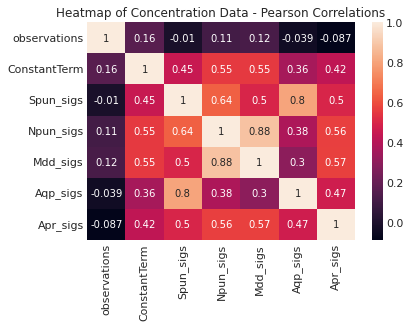

In [49]:
correlations = df.corr()
# annot=True displays the correlation values
sns.heatmap(correlations, annot=True).set(title='Heatmap of Concentration Data - Pearson Correlations');

In [53]:
# Note the difference in argument order
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.529
Model:                            OLS   Adj. R-squared (uncentered):              0.523
Method:                 Least Squares   F-statistic:                              81.01
Date:                Tue, 26 Jul 2022   Prob (F-statistic):                    8.42e-57
Time:                        19:45:14   Log-Likelihood:                          128.38
No. Observations:                 365   AIC:                                     -246.8
Df Residuals:                     360   BIC:                                     -227.3
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Spun_sigs     -1.5853      6.085     -0.261      0.795     -13.551      10.380
Npun_sigs     -6.4328     18.785     -0.342      0.732     -43.376      30.510
Mdd_sigs     -47.6556     19.761     -2.412      0.016     -86.518      -8.793
Aqp_sigs     -63.1538     28.951     -2.181      0.030    -120.089      -6.219
Apr_sigs     -31.9391      8.454     -3.778      0.000     -48.565     -15.314
==============================================================================
Omnibus:                       72.991   Durbin-Watson:                   0.804
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              137.578
Skew:                           1.090   Prob(JB):                     1.33e-30
Kurtosis:                       5.072   Cond. No.                         17.0
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [54]:
import statsmodels.formula.api as smf
ksf =  smf.ols('observations-ConstantTerm ~+Spun_sigs +Npun_sigs+Mdd_sigs+Aqp_sigs+Apr_sigs', data=df)
ksf_res = ksf.fit()
ksf_res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           observations   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     4.115
Date:                Tue, 26 Jul 2022   Prob (F-statistic):            0.00120
Time:                        19:51:35   Log-Likelihood:                 190.20
No. Observations:                 365   AIC:                            -368.4
Df Residuals:                     359   BIC:                            -345.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.8846      0.013     68.988      0.000       0.859       0.910
Spun_sigs     -5.4476      5.170     -1.054      0.293     -15.615       4.720
Npun_sigs     17.3731     15.916      1.092      0.276     -13.928      48.674
Mdd_sigs      24.8342     17.266      1.438      0.151      -9.122      58.790
Aqp_sigs      15.9232     25.082      0.635      0.526     -33.402      65.249
Apr_sigs     -24.4443      7.151     -3.418      0.001     -38.507     -10.381
==============================================================================
Omnibus:                      104.601   Durbin-Watson:                   0.876
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              368.370
Skew:                           1.243   Prob(JB):                     1.02e-80
Kurtosis:                       7.248   Cond. No.                     3.48e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.48e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
round(df.corr(),2)

,observations,ConstantTerm,Spun_sigs,Npun_sigs,Mdd_sigs,Aqp_sigs,Apr_sigs
observations,1.00,0.16,-0.01,0.11,0.12,-0.04,-0.09
ConstantTerm,0.16,1.00,0.45,0.55,0.55,0.36,0.42
Spun_sigs,-0.01,0.45,1.00,0.64,0.50,0.80,0.50
Npun_sigs,0.11,0.55,0.64,1.00,0.88,0.38,0.56
Mdd_sigs,0.12,0.55,0.50,0.88,1.00,0.30,0.57
Aqp_sigs,-0.04,0.36,0.80,0.38,0.30,1.00,0.47
Apr_sigs,-0.09,0.42,0.50,0.56,0.57,0.47,1.00


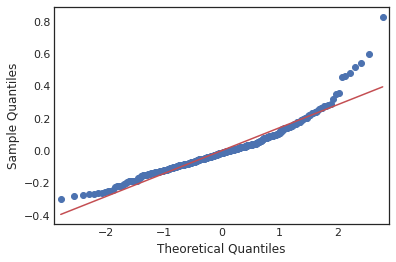

In [44]:
sm.qqplot(ksf_res.resid, line='s');

/home/tzd/anaconda3/envs/Jlab/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


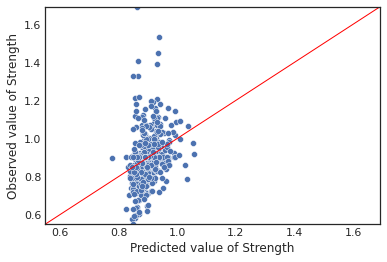

In [45]:
import matplotlib.pyplot as plt
import numpy as np

Y_max = Y.max()
Y_min = Y.min()

ax = sns.scatterplot(ksf_res.fittedvalues, Y)
ax.set(ylim=(Y_min, Y_max))
ax.set(xlim=(Y_min, Y_max))
ax.set_xlabel("Predicted value of Strength")
ax.set_ylabel("Observed value of Strength")

X_ref = Y_ref = np.linspace(Y_min, Y_max, 100)
plt.plot(X_ref, Y_ref, color='red', linewidth=1)
plt.show()

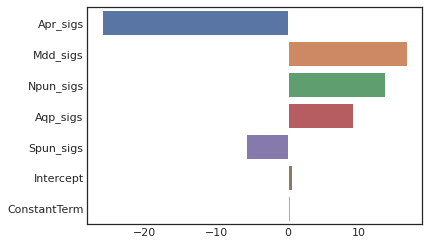

In [46]:
coeff =ksf_res.params
coeff = coeff.iloc[(coeff.abs()*-1.0).argsort()]
sns.barplot(x=coeff.values, y=coeff.index, orient='h');

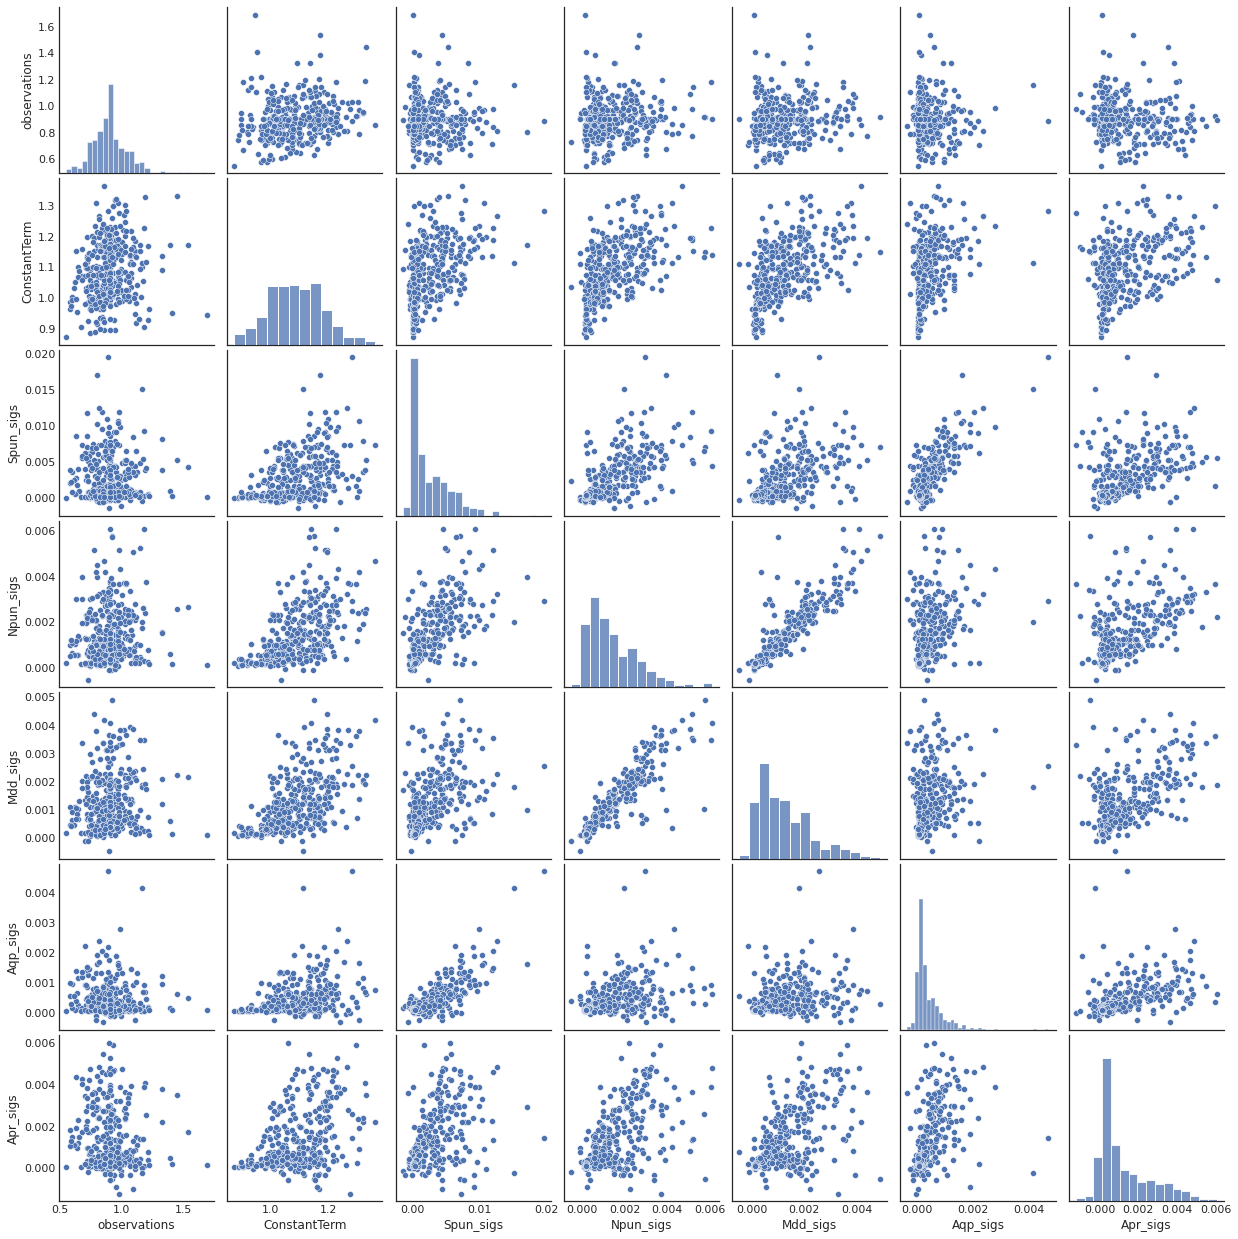

In [48]:
sns.pairplot(df)

## Set Up the Model

In [4]:
def set_metric(metric_type):
    if metric_type=='95th':
        print("model metric is 95th percentile")
        def model(theta):
            """Dummy model used here for Bayesian analysis (replace with actual GEOS-Chem function):
                Model: Y = f(theta) where theta is a set of parameters:
                    Emissions: E1, E2, and E3
            """
            Espun, Enpun, Emdd, Eaqp, Eapr=theta
            
            modified=ConstantTerm+ (Espun*Spun_sigs) + (Enpun*Npun_sigs) + (Emdd*Mdd_sigs) +(Eaqp*Aqp_sigs) +Eapr*Apr_sigs 
            
            summary =pd.DataFrame(modified)
            model_out = list(summary.apply(find_95th))

            return model_out
    elif metric_type=='mean':
        print("model metric is mean")
        def model(theta):
            Espun, Enpun, Emdd, Eaqp, Eapr=theta
            
            modified=ConstantTerm+ (Espun*Spun_sigs) + (Enpun*Npun_sigs) + (Emdd*Mdd_sigs) +(Eaqp*Aqp_sigs) +Eapr*Apr_sigs 
            model_out = list(modified.mean(axis=0))

            return model_out
    else:
        print("model metric is IQR")
        def model(theta):
            Espun, Enpun, Emdd, Eaqp, Eapr=theta
            
            modified=ConstantTerm+ (Espun*Spun_sigs) + (Enpun*Npun_sigs) + (Emdd*Mdd_sigs) +(Eaqp*Aqp_sigs) +Eapr*Apr_sigs 
            model_out = list(iqr(modified, axis=0))

            return model_out
    return model

### Sanity Check

#### Initialize constants 

In [5]:
# ConstantTerm,Spun_sigs,Npun_sigs,Mdd_sigs,Aqp_sigs,Apr_sigs=initEmcee(2)

#### Run model function

In [6]:
# #Testing Modelling function
# thet = [10,13,60,25,1]
# model = set_metric('90th')

# print('The 90th for [10,13,60,25,1] percentiles are')
# print(model(thet))
# print('The 90th for [14,13,40,25,10] percentiles are')
# print(model([14,13,40,25,10]))

# print('\n The means are')
# model = set_metric('mean')
# print(model(thet))
# print('\n The means for [14,13,40,25,10] are:')
# print(model([14,13,40,25,10]))

# print('\n The IQRs are')
# model = set_metric('iqr')
# print(model(thet))
# print('\n The IQRs for [14,13,40,25,10] are:')
# print(model([14,13,40,25,10]))



## Set Up MCMC Parameters

In [7]:
def lnlike(theta, y_obs, y_err):

   """Calculating log likelihood assuming iid Gaussian errors
       Parameters
       ----------
       theta : parameters
       y_obs : observed value (e.g. of IQR)
       y_err : error in observed value (e.g. of IQR)"""
   y = model(theta) # calculate modelled output
    # calculate log-likelihood that observed value is drawn from normal
    # distribution with mean y (modelled value) and sigma = y_err
   # if len(y)== 1:
   #    LnLike = norm.logpdf(y_obs, y, y_err)
   # else:
   #    print('somehting is wrong')
   LnLike = sum(norm.logpdf(y_obs, y, y_err))
   return LnLike

In [8]:
def lnprior(theta):
    """Apply prior assumption bounds (i.e. upper and lower bounds of variables)
       Parameters
       ----------
       theta : parameters    
    """
    
    E1, E2, E3, E4, E5 = theta
    
    # Prior assumptions for emissions - vary between 0 and 100 (can adjust this):
    min_emiss = 0
    max_emiss = 100 
    
    if E1 <= min_emiss or E2 <= min_emiss or E3 <= min_emiss or E4 <= min_emiss or E5 <= min_emiss: # enforce lower bound
        return -np.inf
    elif E1 >= max_emiss or E2 >= max_emiss or E3 >= max_emiss or E4 >= max_emiss or E5 >= max_emiss: # enforce upper bound
        return -np.inf
    else: # all values within prior bounds
        return 0.0
    

In [9]:
def lnprob(theta, y_obs, y_err):
    """Overall function that calculates log likelihood probability
       Parameters
       ----------
       theta : parameters  
       y_obs : observed value (e.g. of IQR)   
       y_err : error in observed value (e.g. of IQR)      
    """
    
    lp = lnprior(theta) #call lnprior
    if not np.isfinite(lp): # check if lp is non-zero:
        return -np.inf
    else: #recall if lp not -inf, its 0, so this just returns likelihood
        return lp + lnlike(theta, y_obs, y_err) 


### Sanity Check

In [10]:
# import numpy as np
# rng = np.random.default_rng()
# from scipy.stats import norm
# dist = norm(loc=2, scale=4)  # our "unknown" distribution
# data = dist.rvs(size=100, random_state=rng)


In [11]:
# import numpy as np
# from sklearn.experimental import enable_iterative_imputer
# from sklearn.impute import IterativeImputer
# from sklearn.linear_model import LinearRegression
# X=np.array(list(obs_Hg0_d['value'])).reshape(-1, 1)
# lr = LinearRegression()
# imp = IterativeImputer(estimator=lr,missing_values=np.nan, max_iter=10, verbose=2, imputation_order='roman',random_state=0)
# X=imp.fit_transform(X)
# X

In [12]:
# get_detrended_obs()[get_detrended_obs()['value'].isnull()==True]

In [13]:
# def fun_95th(sample,axis): #function for calculating iqr
#     iqr = np.quantile(sample, 0.975,axis) - np.quantile(sample, 0.025,axis) 
#     return iqr

In [14]:
# refsitenum = 0
# data = get_detrended_obs().to_numpy()
# res = bootstrap((data,), fun_95th)
# np.array(res.standard_error).mean()

In [15]:
# refsitenum = 1
# data=getBoxesAround(refsitenum).values
# res = bootstrap((data,), np.mean)
# (np.array(res.standard_error)).mean()

In [ ]:
# refsitenum = 1
# ConstantTerm,Spun_sigs,Npun_sigs,Mdd_sigs,Aqp_sigs,Apr_sigs=initEmcee(refsitenum)
# initial = np.array([7.75, 11.66, 1.39, 13.63, 18.99])
# print(np.array(getBoxesAround(refsitenum).mean()))
# model = set_metric('mean')
# print('model output')
# model(initial)

## Set Up Run

In [16]:
def fun_95th(sample,axis): #function for calculating iqr
    iqr = np.quantile(sample, 0.975,axis) - np.quantile(sample, 0.025,axis) 
    return iqr

In [17]:
# fun_95th(get_detrended_obs().value,0)

In [18]:
def fun_iqr(sample,axis): #function for calculating 95th percentile range
    result = np.quantile(sample, 0.75,axis) - np.quantile(sample, 0.25,axis) 
    return result

In [21]:
def run_simulation(RefSiteNum,metric,init):
    
    
    #theta_true = (E1_true, E2_true, E3_true,E4_true, E5_true)
    if metric == '95th':
        y_true = fun_95th(obs_Hg0_d['value'],0)
        data = obs_Hg0_d['value'].to_numpy()
        res = bootstrap((data,), fun_95th)
        y_err = (np.array(res.standard_error)).mean()
        print(f"The true value of y is: {y_true} \n ")
        print(f"the error is: {y_err}")
    elif metric == 'mean':
        y_true = obs_Hg0_d['value'].mean()
        data = obs_Hg0_d['value'].to_numpy()
        res = bootstrap((data,), np.mean)
        y_err = (np.array(res.standard_error)).mean()
        print(f"The true value of y is: {y_true} \n")
        print(f"the error is: {y_err}")
    else:
        y_true = getObsIQR(obs_Hg0_d)
        data=obs_Hg0_d['value']
        res = bootstrap((data,), fun_iqr)
        y_err = (np.array(res.standard_error)).mean()

    initial = init

    ndim = len(initial)
    # hyperparameter for jump size between guesses
    step_size = 1e-5 
    # number of chains to run simultaneously and their length
    nwalkers = 100
    niter = 1000

    # setting initial guesses for all of the chains
    p0 = [np.array(initial) + step_size * np.random.randn(ndim) for i in range(nwalkers)]

    sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob, args=(y_true, y_err))
    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 500)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)
    return sampler

In [20]:
def run_simulation_error(RefSiteNum,metric,init,error):
    
    
    #theta_true = (E1_true, E2_true, E3_true,E4_true, E5_true)
    if metric == '95th':
        y_true = fun_95th(get_detrended_obs().value,0)
        y_err = error
        print(f"The true value of y is: {y_true} \n ")
        print(f"the error is: {y_err}")
    elif metric == 'mean':
        y_true = obs_Hg0_d['value'].mean()
        y_err = error
        print(f"The true value of y is: {y_true} \n")
        print(f"the error is: {y_err}")
    else:
        y_true = getObsIQR(get_detrended_obs())
        y_err = error

    initial = init

    ndim = len(initial)
    # hyperparameter for jump size between guesses
    step_size = 1e-5 
    # number of chains to run simultaneously and their length
    nwalkers = 50
    niter = 1000

    # setting initial guesses for all of the chains
    p0 = [np.array(initial) + step_size * np.random.randn(ndim) for i in range(nwalkers)]

    sampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob, args=(y_true, y_err))
    print("Running burn-in...")
    p0, _, _ = sampler.run_mcmc(p0, 500)
    sampler.reset()

    print("Running production...")
    pos, prob, state = sampler.run_mcmc(p0, niter)
    return sampler